In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import os
import math
from collections import Counter
from torch.utils.data import DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from torchmetrics.functional.text import bleu_score
import spacy
import matplotlib.pyplot as plt

# Load Spacy
spacy_eng = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

In [2]:

# --- 1. VOCABULARY CLASS ---
class Vocabulary:
    def __init__(self, freq_threshold=2, max_size=80000):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        self.max_size = max_size

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    @staticmethod
    def tokenizer_fr(text):
        return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

    def build_vocabulary(self, sentence_list, tokenizer):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in tokenizer(sentence):
                frequencies[word] += 1
        common_words = frequencies.most_common(self.max_size - 4)
        for word, count in common_words:
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text, tokenizer):
        tokenized_text = tokenizer(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

# --- 2. DATASET CLASS (WITH REVERSING) ---
class WMT14Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, source_vocab, target_vocab):
        self.hf_dataset = hf_dataset
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, index):
        pair = self.hf_dataset[index]['translation']
        src_text = pair['en']
        trg_text = pair['fr']

        # Numericalize and REVERSE Source
        src_indices = self.source_vocab.numericalize(src_text, self.source_vocab.tokenizer_eng)
        src_indices = src_indices[::-1] # <--- REVERSING INPUT HERE
        
        numericalized_source = [self.source_vocab.stoi["<SOS>"]] + src_indices + [self.source_vocab.stoi["<EOS>"]]
        numericalized_target = [self.target_vocab.stoi["<SOS>"]] + \
                               self.target_vocab.numericalize(trg_text, self.target_vocab.tokenizer_fr) + \
                               [self.target_vocab.stoi["<EOS>"]]

        return torch.tensor(numericalized_source), torch.tensor(numericalized_target)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    def __call__(self, batch):
        source = [item[0] for item in batch]
        target = [item[1] for item in batch]
        source = pad_sequence(source, batch_first=False, padding_value=self.pad_idx)
        target = pad_sequence(target, batch_first=False, padding_value=self.pad_idx)
        return source, target

# --- 3. MODEL ARCHITECTURE ---
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            input = trg[t]
        return outputs

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [3]:
class BucketBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, noise=0.1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.noise = noise # Adds a little randomness to the sorting so batches aren't identical every epoch
        
        # 1. Pre-calculate lengths of all source sentences
        # (This takes a moment at startup but saves huge time during training)
        print("Calculating dataset lengths for bucketing...")
        self.lengths = []
        for i in range(len(dataset)):
            # Access the raw text directly from the HF dataset to be fast
            src_text = dataset.hf_dataset[i]['translation']['en']
            self.lengths.append(len(src_text)) # approximate length by char count (faster) or use tokenizer
            
    def __iter__(self):
        # 2. Create indices and add noise to lengths
        # We add random noise to lengths so the sort order changes slightly every epoch
        indices = list(range(len(self.dataset)))
        
        # Zip indices with their noisy lengths
        noisy_lengths = [l + random.uniform(-self.noise, self.noise) for l in self.lengths]
        indices_with_lens = list(zip(indices, noisy_lengths))
        
        # 3. Sort by length
        indices_with_lens.sort(key=lambda x: x[1])
        sorted_indices = [x[0] for x in indices_with_lens]
        
        # 4. Create batches
        # Since the list is sorted, chunks of 'batch_size' will naturally have similar lengths
        batches = [sorted_indices[i:i + self.batch_size] for i in range(0, len(sorted_indices), self.batch_size)]
        
        # 5. Shuffle the BATCHES (Important!)
        # We want to train on similar-length sentences together, 
        # BUT we don't want to always train on short sentences first and long ones last.
        random.shuffle(batches)
        
        # Yield one batch at a time
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [4]:
# --- CONFIGURATION ---
BATCH_SIZE = 32
SUBSET_SIZE = 10000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

# 1. Load Data
dataset = load_dataset("wmt14", "fr-en")
train_subset = dataset['train'].select(range(SUBSET_SIZE))
valid_subset = dataset['validation'].select(range(1000))

# 2. Build Vocab
print("Building Vocabularies...")
vocab_en = Vocabulary(freq_threshold=1, max_size=80000)
vocab_en.build_vocabulary([item['translation']['en'] for item in train_subset], vocab_en.tokenizer_eng)

vocab_fr = Vocabulary(freq_threshold=1, max_size=80000)
vocab_fr.build_vocabulary([item['translation']['fr'] for item in train_subset], vocab_fr.tokenizer_fr)

print(f"Unique English Words: {len(vocab_en)}")
print(f"Unique French Words: {len(vocab_fr)}")

# 3. DataLoaders
pad_idx = vocab_en.stoi["<PAD>"]

# Create the Dataset (No change here)
train_dataset_obj = WMT14Dataset(train_subset, vocab_en, vocab_fr)

# Initialize the Bucket Sampler
# This replaces the 'shuffle=True' standard logic
bucket_sampler = BucketBatchSampler(train_dataset_obj, batch_size=BATCH_SIZE)

# Create the DataLoader
train_loader = DataLoader(
    train_dataset_obj,
    batch_sampler=bucket_sampler, # <--- Pass the custom sampler here
    num_workers=0,
    collate_fn=MyCollate(pad_idx)
)

print("Optimized DataLoader ready.")

Using Device: mps


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Building Vocabularies...
Unique English Words: 10731
Unique French Words: 14472
Calculating dataset lengths for bucketing...
Optimized DataLoader ready.


In [5]:
# --- HYPERPARAMETERS ---
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)
ENC_EMB_DIM = 1000
DEC_EMB_DIM = 1000
HID_DIM = 1000
N_LAYERS = 4
DROPOUT = 0.2
N_EPOCHS = 20 
CLIP = 5
TRG_PAD_IDX = vocab_fr.stoi["<PAD>"]
SEEDS = [1, 2, 3, 4, 5]

def train_one_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# --- TRAINING LOOP FOR 5 MODELS ---
for seed in SEEDS:
    print(f"\n{'='*20}")
    print(f"TRAINING MODEL {seed}/5 (Seed: {seed})")
    print(f"{'='*20}")
    
    # 1. Set Seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available(): torch.mps.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed(seed)
    
    # 2. Initialize Fresh Model
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
    model.apply(init_weights) # Paper initialization
    
    # 3. Optimizer & Criterion
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
    
    # 4. Train
    for epoch in range(N_EPOCHS):
        loss = train_one_epoch(model, train_loader, optimizer, criterion, CLIP)
        print(f"Seed {seed} | Epoch {epoch+1} | Loss: {loss:.3f} | PPL: {math.exp(loss):.2f}")
        
    # 5. Save Model
    save_path = f"ensembel_model_seed_{seed}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"--> Saved {save_path}")

print("\nAll 5 models trained and saved successfully.")


TRAINING MODEL 1/5 (Seed: 1)
Seed 1 | Epoch 1 | Loss: 6.386 | PPL: 593.48
Seed 1 | Epoch 2 | Loss: 5.711 | PPL: 302.12
Seed 1 | Epoch 3 | Loss: 5.091 | PPL: 162.54
Seed 1 | Epoch 4 | Loss: 4.668 | PPL: 106.47
Seed 1 | Epoch 5 | Loss: 4.366 | PPL: 78.71
Seed 1 | Epoch 6 | Loss: 4.143 | PPL: 62.96
Seed 1 | Epoch 7 | Loss: 3.959 | PPL: 52.38
Seed 1 | Epoch 8 | Loss: 3.795 | PPL: 44.47
Seed 1 | Epoch 9 | Loss: 3.646 | PPL: 38.32
Seed 1 | Epoch 10 | Loss: 3.512 | PPL: 33.52
Seed 1 | Epoch 11 | Loss: 3.389 | PPL: 29.62
Seed 1 | Epoch 12 | Loss: 3.267 | PPL: 26.24
Seed 1 | Epoch 13 | Loss: 3.153 | PPL: 23.40
Seed 1 | Epoch 14 | Loss: 3.045 | PPL: 21.02
Seed 1 | Epoch 15 | Loss: 2.938 | PPL: 18.89
Seed 1 | Epoch 16 | Loss: 2.834 | PPL: 17.01
Seed 1 | Epoch 17 | Loss: 2.732 | PPL: 15.36
Seed 1 | Epoch 18 | Loss: 2.635 | PPL: 13.94
Seed 1 | Epoch 19 | Loss: 2.541 | PPL: 12.69
Seed 1 | Epoch 20 | Loss: 2.446 | PPL: 11.54
--> Saved ensembel_model_seed_1.pt

TRAINING MODEL 2/5 (Seed: 2)
Seed 2 | E

In [6]:
def beam_search_decode_ensemble(models_list, sentence, vocab_src, vocab_trg, beam_size=2, max_len=50, device='cpu'):
    # Ensure models are in eval mode
    for m in models_list: m.eval()
    
    # Prepare Input
    if isinstance(sentence, str): tokens = vocab_src.tokenizer_eng(sentence)
    else: tokens = [token.lower() for token in sentence]
    
    indices = [vocab_src.stoi.get(t, vocab_src.stoi["<UNK>"]) for t in tokens]
    indices = indices[::-1] # REVERSE
    indices = [vocab_src.stoi["<SOS>"]] + indices + [vocab_src.stoi["<EOS>"]]
    src_tensor = torch.LongTensor(indices).unsqueeze(1).to(device)

    with torch.no_grad():
        # Encoder states for all models
        initial_states = []
        for m in models_list:
            h, c = m.encoder(src_tensor)
            initial_states.append((h, c))

        hypotheses = [(0.0, [vocab_trg.stoi["<SOS>"]], initial_states)]

        for _ in range(max_len):
            all_candidates = []
            for score, seq, states_list in hypotheses:
                if seq[-1] == vocab_trg.stoi["<EOS>"]:
                    all_candidates.append((score, seq, states_list))
                    continue
                
                last_token = torch.LongTensor([seq[-1]]).to(device)
                
                # Run all models and AVERAGE logits
                avg_log_probs = None
                new_states_list = []
                for i, m in enumerate(models_list):
                    prev_h, prev_c = states_list[i]
                    pred, new_h, new_c = m.decoder(last_token, prev_h, prev_c)
                    new_states_list.append((new_h, new_c))
                    
                    # Squeeze the batch dimension: [1, vocab_size] -> [vocab_size]
                    pred = pred.squeeze(0)
                    
                    log_probs = F.log_softmax(pred, dim=0)
                    if avg_log_probs is None: avg_log_probs = log_probs
                    else: avg_log_probs += log_probs
                
                avg_log_probs = avg_log_probs / len(models_list)
                top_k_probs, top_k_ids = avg_log_probs.topk(beam_size * 2)

                for i in range(len(top_k_ids)):
                    all_candidates.append((score + top_k_probs[i].item(), seq + [top_k_ids[i].item()], new_states_list))

            hypotheses = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_size]
            if all(h[1][-1] == vocab_trg.stoi["<EOS>"] for h in hypotheses): break

    best_seq = hypotheses[0][1]
    decoded_words = [vocab_trg.itos[idx] for idx in best_seq]
    if "<SOS>" in decoded_words: decoded_words.remove("<SOS>")
    if "<EOS>" in decoded_words: decoded_words = decoded_words[:decoded_words.index("<EOS>")]
    return " ".join(decoded_words)

# --- BLEU EVALUATOR ---
def evaluate_ensemble(data_subset, models_list, vocab_src, vocab_trg, device, beam_size, n_gram=4):
    targets = []
    predictions = []
    print(f"Evaluating Ensemble on {len(data_subset)} samples...")
    
    for i, datum in enumerate(data_subset):
        if (i+1)%50 == 0: print(f"Processed {i+1}...")
        pair = datum['translation']
        pred = beam_search_decode_ensemble(     
                models_list, 
                pair['en'], 
                vocab_src, 
                vocab_trg, 
                beam_size, 
                max_len=50, # Optional: Explicitly set max_len here if you want
                device=device
            )
        targets.append([pair['fr']])
        predictions.append(pred)
        
    return bleu_score(predictions, targets, n_gram=n_gram).item() * 100

In [7]:
# Load the 5 Saved Models
ensemble_models = []
print("Loading Ensemble Models...")

for seed in SEEDS:
    # Re-instantiate architecture
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    m = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
    
    # Load weights
    m.load_state_dict(torch.load(f"ensembel_model_seed_{seed}.pt", weights_only=True))
    ensemble_models.append(m)
    print(f"Loaded model_seed_{seed}.pt")

# Sanity Check
print("\n--- Manual Ensemble Check ---")
test_sen = "the cat sat on the mat"
print(f"Input: {test_sen}")
print(f"Output: {beam_search_decode_ensemble(ensemble_models, test_sen, vocab_en, vocab_fr, beam_size=2, device=DEVICE)}")


Loading Ensemble Models...
Loaded model_seed_1.pt
Loaded model_seed_2.pt
Loaded model_seed_3.pt
Loaded model_seed_4.pt
Loaded model_seed_5.pt

--- Manual Ensemble Check ---
Input: the cat sat on the mat
Output: question no la )


In [8]:

# Final BLEU Score
n_grams_l = [1, 2, 3, 4]
for _,n in enumerate(n_grams_l):
    final_score = evaluate_ensemble(valid_subset, ensemble_models, vocab_en, vocab_fr, DEVICE, beam_size=2, n_gram=n)
    print(f"\n=================================")
    print(f"FINAL ENSEMBLE BLEU SCORE with n_gram={n}: {final_score:.2f}")
    print(f"=================================")

Evaluating Ensemble on 1000 samples...
Processed 50...
Processed 100...
Processed 150...
Processed 200...
Processed 250...
Processed 300...
Processed 350...
Processed 400...
Processed 450...
Processed 500...
Processed 550...
Processed 600...
Processed 650...
Processed 700...
Processed 750...
Processed 800...
Processed 850...
Processed 900...
Processed 950...
Processed 1000...

FINAL ENSEMBLE BLEU SCORE with n_gram=1: 9.87
Evaluating Ensemble on 1000 samples...
Processed 50...
Processed 100...
Processed 150...
Processed 200...
Processed 250...
Processed 300...
Processed 350...
Processed 400...
Processed 450...
Processed 500...
Processed 550...
Processed 600...
Processed 650...
Processed 700...
Processed 750...
Processed 800...
Processed 850...
Processed 900...
Processed 950...
Processed 1000...

FINAL ENSEMBLE BLEU SCORE with n_gram=2: 2.70
Evaluating Ensemble on 1000 samples...
Processed 50...
Processed 100...
Processed 150...
Processed 200...
Processed 250...
Processed 300...
Processe

The following code compares the BLEU results of our implementation with the paper's implementation. These discrepancies are expected and are based on the following reasons:

1. Data Size: The paper was trained on 12M sentences, whereas we chose only 10k sentences. This equals 0.08% of the training data. Our model most probably memorized the training set but has zero ability to generalize to the unseen validation set (1k samples). That is why we have a 0.00 score for 3-grams and 4-grams, but 9.23 for BLEU-1 and 2.76 for BLEU-2, respectively.

2. Vocabulary Size: The paper's vocabulary (160k source and 80k target) is huge versus our implementation, where the vocabulary was built from only 10,000 sentences. This limits the words the model recognizes in the validation set; it likely generates many "unknown" tokens, which affects the predictions as well.

3. Beam Search: We used a beam size of 2, so we presented both the paper's best BLEU for this task and the specific result they reported for a beam size of 2.

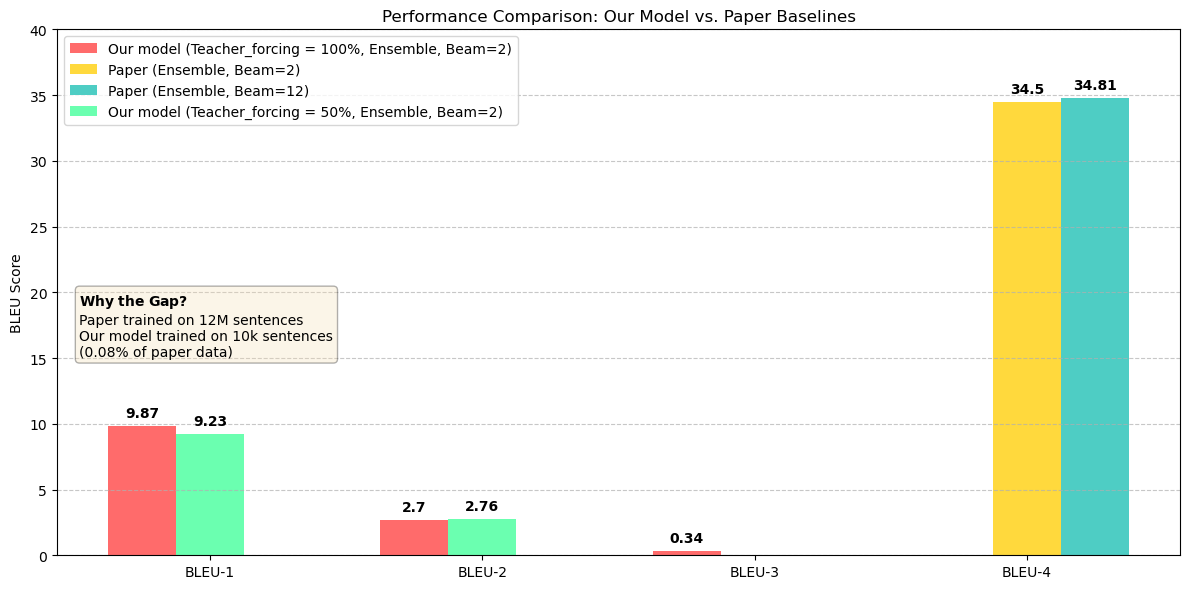

In [18]:

# --- DATA ---
# 1. Our Results
scores_Teacher_forcing_1 = {
    'BLEU-1': 9.87,
    'BLEU-2': 2.70,
    'BLEU-3': 0.34,
    'BLEU-4': 0.00
}

scores_Teacher_forcing_05 = {
    'BLEU-1': 9.23,
    'BLEU-2': 2.76,
    'BLEU-3': 0.00,
    'BLEU-4': 0.00
}

# 2. Paper Results (Sutskever et al., 2014) - Table 1
# Trained on 12M sentences (Full WMT14)
paper_ensemble_beam_2 = 34.50   # Ensemble of 5, Beam=2
paper_ensemble_beam_12 = 34.81  # Ensemble of 5, Beam=12 (Best Reported)

# --- PLOTTING ---
# We will plot groups of bars.

labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']

# Your values across n-grams
Teacher_forcing_1 = [scores_Teacher_forcing_1['BLEU-1'], scores_Teacher_forcing_1['BLEU-2'], scores_Teacher_forcing_1['BLEU-3'], scores_Teacher_forcing_1['BLEU-4']]
Teacher_forcing_05 = [scores_Teacher_forcing_05['BLEU-1'], scores_Teacher_forcing_05['BLEU-2'], scores_Teacher_forcing_05['BLEU-3'], scores_Teacher_forcing_05['BLEU-4']]

# Paper values (Only BLEU-4 is standard reporting, filling others with 0 for visual clarity)
paper_beam2_values = [0, 0, 0, paper_ensemble_beam_2]
paper_beam12_values = [0, 0, 0, paper_ensemble_beam_12]

x = np.arange(len(labels))
width = 0.25  # Thinner bars to fit 3 side-by-side

fig, ax = plt.subplots(figsize=(12, 6))

# Teacher forcing 1.0 BeamSize 2
rects1 = ax.bar(x - width, Teacher_forcing_1, width, label='Our model (Teacher_forcing = 100%, Ensemble, Beam=2)', color='#FF6B6B')

# Paper Beam Size 2
# We only plot the bar at index 3 (BLEU-4) to avoid confusion, as paper didn't report BLEU 1-3
rects2 = ax.bar(x[3], paper_ensemble_beam_2, width, label='Paper (Ensemble, Beam=2)', color='#FFD93D')

# Paper Beam Size 12
rects3 = ax.bar(x[3] + width, paper_ensemble_beam_12, width, label='Paper (Ensemble, Beam=12)', color='#4ECDC4')

# Teacher_forcing 0.5 BeamSize 2
rects4 = ax.bar(x, Teacher_forcing_05, width, label='Our model (Teacher_forcing = 50%, Ensemble, Beam=2)', color="#6BFFB0")

# Formatting
ax.set_ylabel('BLEU Score')
ax.set_title('Performance Comparison: Our Model vs. Paper Baselines')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_ylim(0, 40)

# Add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Add a text box to explain the gap
textstr = '\n'.join((
    r'$\bf{Why\ the\ Gap?}$',
    r'Paper trained on 12M sentences',
    r'Our model trained on 10k sentences',
    r'(0.08% of paper data)'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.02, 0.5, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [19]:
# Load the 5 Saved Models
ensemble_models = []
print("Loading Ensemble Models...")

for seed in SEEDS:
    # Re-instantiate architecture
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
    m = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
    
    # Load weights
    m.load_state_dict(torch.load(f"ensembel_model_seed_{seed}.pt", weights_only=True))
    ensemble_models.append(m)    
print(f"--- DIAGNOSIS: VISUAL INSPECTION ---")

for i in range(5):
    idx = random.randint(0, len(valid_subset)-1)
    pair = valid_subset[idx]['translation']
    src = pair['en']
    trg = pair['fr']
    
    pred = beam_search_decode_ensemble(ensemble_models, src, vocab_en, vocab_fr, beam_size=2, device=DEVICE)
    
    print(f"Input:  {src}")
    print(f"Target: {trg}")
    print(f"Output: {pred}")
    print("-" * 30)

Loading Ensemble Models...
--- DIAGNOSIS: VISUAL INSPECTION ---
Input:  That is where our staff and regular customers left for.
Target: Nos employés y sont partis en tant qu'habitués.
Output: il est donc de l' une de la . .
------------------------------
Input:  French troops have left their area of responsibility in Afghanistan (Kapisa and Surobi).
Target: Les troupes françaises ont quitté leur zone de responsabilité en Afghanistan (Kapisa et Surobi).
Output: il n' a en ailleurs de la politique de la politique de la . .
------------------------------
Input:  It became clear to me that this is my path.
Target: J'ai compris que c'était ma voie.
Output: c' est la raison pour la le . .
------------------------------
Input:  The Embassy has received dozens of written requests for small agricultural projects from local communities in Kapisa province.
Target: L'ambassade a reçu des dizaines de demandes écrites de petites réalisations agricoles émanant de communautés locales de la province de

In [48]:
# --- 1. Create Micro-Dataset (Only 50 items) ---
micro_subset = dataset['train'].select(range(50)) # First 50 sentences only

# Re-build vocab on JUST these 50 sentences to ensure no <UNK>s
vocab_en_micro = Vocabulary(freq_threshold=1, max_size=1000)
vocab_en_micro.build_vocabulary([item['translation']['en'] for item in micro_subset], vocab_en_micro.tokenizer_eng)

vocab_fr_micro = Vocabulary(freq_threshold=1, max_size=1000)
vocab_fr_micro.build_vocabulary([item['translation']['fr'] for item in micro_subset], vocab_fr_micro.tokenizer_fr)

# Loaders
pad_idx_micro = vocab_en_micro.stoi["<PAD>"]
micro_loader = DataLoader(
    WMT14Dataset(micro_subset, vocab_en_micro, vocab_fr_micro),
    batch_size=10, 
    shuffle=True, 
    collate_fn=MyCollate(pad_idx_micro)
)

# --- 2. Setup Model (Tiny Config) ---
INPUT_DIM = len(vocab_en_micro)
OUTPUT_DIM = len(vocab_fr_micro)
ENC_EMB_DIM = 64  
DEC_EMB_DIM = 64
HID_DIM = 128     
N_LAYERS = 1      
DROPOUT = 0.0     # NO DROPOUT (We WANT to overfit)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=0.005) 
criterion = nn.CrossEntropyLoss(ignore_index=vocab_fr_micro.stoi["<PAD>"])

# --- 3. Train for 100 Epochs (Force Memorization) ---
print("--- STARTING MICRO-TRAINING ---")
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for src, trg in micro_loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss / len(micro_loader):.4f}")

# --- 4. Verify ---
print("\n--- VISUAL CHECK (Should be Perfect) ---")

# Pick the FIRST sentence (index 0) to verify memorization
pair = micro_subset[0]['translation']
src = pair['en']
trg = pair['fr']

# CHANGE HERE: Use beam_search_decode_ensemble
# We wrap 'model' in a list [model] because the function expects a list of models
pred = beam_search_decode_ensemble(
    [model],  # <--- Passed as a list
    src, 
    vocab_en_micro, 
    vocab_fr_micro, 
    beam_size=2, 
    device=DEVICE
)

print(f"Input: {src}")
print(f"Target: {trg}")
print(f"Pred:   {pred}")

--- STARTING MICRO-TRAINING ---
Epoch 10 | Loss: 4.8615
Epoch 20 | Loss: 4.4688
Epoch 30 | Loss: 4.1603
Epoch 40 | Loss: 3.5409
Epoch 50 | Loss: 3.0849
Epoch 60 | Loss: 2.2138
Epoch 70 | Loss: 2.0601
Epoch 80 | Loss: 1.0979
Epoch 90 | Loss: 0.6567
Epoch 100 | Loss: 0.6433

--- VISUAL CHECK (Should be Perfect) ---
Input: Resumption of the session
Target: Reprise de la session
Pred:   madame la présidente , conformément à l' orientation désormais constamment exprimée par le parlement européen , les citoyens d' un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles .


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def analyze_length_vs_bleu(models_list, dataset, vocab_src, vocab_trg, device, beam_size=2):
    """
    1. Translates every sentence in the dataset.
    2. Calculates BLEU for that specific sentence.
    3. Groups results by source sentence length.
    4. Plots the distribution.
    """
    
    # Configuration
    # Bins: 0-10, 11-20, 21-30, 31-40, 40+
    bins = {(0, 10): [], (11, 20): [], (21, 30): [], (31, 40): [], (41, 999): []}
    
    print(f"Analyzing {len(dataset)} sentences...")
    smoother = SmoothingFunction().method1 # Helps with short sentences
    
    for i, datum in enumerate(dataset):
        if (i + 1) % 20 == 0: print(f"Processed {i + 1}...")
        
        # 1. Get Data
        pair = datum['translation']
        src_text = pair['en']
        trg_text = pair['fr']
        
        # 2. Calculate Source Length (number of tokens)
        src_tokens = vocab_src.tokenizer_eng(src_text)
        src_len = len(src_tokens)
        
        # 3. Translate
        # Note: We use the beam_search function you already fixed
        pred_text = beam_search_decode_ensemble(
            models_list, 
            src_text, 
            vocab_src, 
            vocab_trg, 
            beam_size=beam_size, 
            device=device
        )
        
        # 4. Calculate Sentence BLEU
        # NLTK expects tokenized lists: [[ref1_tokens]], [hyp_tokens]
        ref_tokens = [t for t in vocab_trg.tokenizer_fr(trg_text)]
        hyp_tokens = [t for t in pred_text.split()] # Assuming pred_text is string
        
        score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoother) * 100
        
        # 5. Assign to Bin
        for bin_range in bins:
            if bin_range[0] <= src_len <= bin_range[1]:
                bins[bin_range].append(score)
                break
    
    # --- PLOTTING ---
    bin_labels = []
    avg_scores = []
    
    print("\n--- Results ---")
    for bin_range, scores in bins.items():
        if len(scores) > 0:
            avg = sum(scores) / len(scores)
        else:
            avg = 0.0
            
        label = f"{bin_range[0]}-{bin_range[1] if bin_range[1] < 999 else '40+'}"
        bin_labels.append(label)
        avg_scores.append(avg)
        print(f"Length {label:10} | Avg BLEU: {avg:.2f} | Count: {len(scores)}")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(bin_labels, avg_scores, color='skyblue', edgecolor='black')
    
    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

    plt.xlabel('Source Sentence Length (Tokens)')
    plt.ylabel('Average BLEU Score')
    plt.title('Translation Quality vs. Sentence Length')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Loading full models...
Successfully loaded all models!
Analyzing 1000 sentences...
Processed 20...
Processed 40...
Processed 60...
Processed 80...
Processed 100...
Processed 120...
Processed 140...
Processed 160...
Processed 180...
Processed 200...
Processed 220...
Processed 240...
Processed 260...
Processed 280...
Processed 300...
Processed 320...
Processed 340...
Processed 360...
Processed 380...
Processed 400...
Processed 420...
Processed 440...
Processed 460...
Processed 480...
Processed 500...
Processed 520...
Processed 540...
Processed 560...
Processed 580...
Processed 600...
Processed 620...
Processed 640...
Processed 660...
Processed 680...
Processed 700...
Processed 720...
Processed 740...
Processed 760...
Processed 780...
Processed 800...
Processed 820...
Processed 840...
Processed 860...
Processed 880...
Processed 900...
Processed 920...
Processed 940...
Processed 960...
Processed 980...
Processed 1000...

--- Results ---
Length 0-10       | Avg BLEU: 2.21 | Count: 200
Lengt

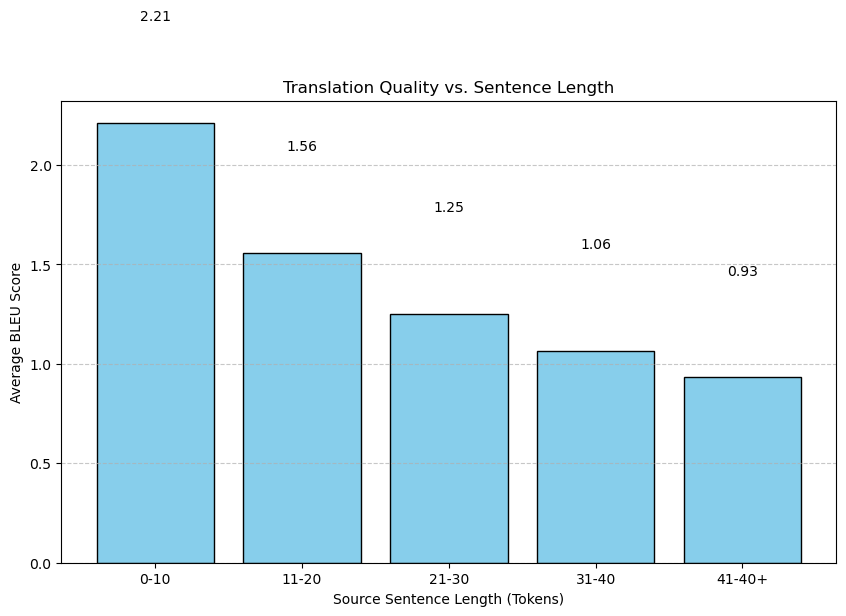

In [12]:
# --- RESET TO FULL MODEL HYPERPARAMETERS ---

# 1. Load the FULL vocabulary
# (Make sure 'vocab_src' and 'vocab_trg' are your ORIGINAL big vocabs, not the micro ones)
INPUT_DIM = len(vocab_en) 
OUTPUT_DIM = len(vocab_fr)

# 2. Use the "Big Model" dimensions (from your earlier prompt)
ENC_EMB_DIM = 1000
DEC_EMB_DIM = 1000
HID_DIM = 1000
N_LAYERS = 4      # <--- This fixes the "Unexpected key" error
DROPOUT = 0.2

# 3. Re-Initialize the Architecture
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

# 4. Now you can load the weights safely
ensemble_models = []
seeds = [1, 2, 3, 4, 5]

print("Loading full models...")
for seed in seeds:
    # Re-create a fresh instance for each seed
    m = Seq2Seq(
        Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT),
        Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT),
        DEVICE
    ).to(DEVICE)
    
    m.load_state_dict(torch.load(f"ensembel_model_seed_{seed}.pt", map_location=DEVICE, weights_only=True))
    ensemble_models.append(m)

print("Successfully loaded all models!")   

analyze_length_vs_bleu(ensemble_models, valid_subset, vocab_en, vocab_fr, DEVICE, beam_size=2)